## Evaluation of Fire Impact on Populated Areas on a European Site
### Geo-storytelling with RACE, EO Dashboard and the Euro Data Cube

This notebook demonstates how to access, combine and analyse data found on the [Rapid Action for Citizens with Earth Observation](https://race.esa.int/) (RACE) and [Earth Observation](https://eodashboard.org/) Dashboard. It uses the EC-JRC's Global Human Settlement (GHS) Layer which contains global data about the total built-up surface from 1975 to 2030 and was derived from Sentinel2 composite and Landsat imagery. The data is openly available and can be downloaded [here](https://ghsl.jrc.ec.europa.eu/ghs_buS2023.php). It was ingested in EDC and provided as a layer, check out the documentation [here](https://github.com/eurodatacube/public-collections/pull/309/commits/43388aadd9ace7d0cb1370f8053a37afed402b86) for further information about the data properties in EDC.
The GHS indicator can be explored on the EO Dashboard by selecting the [EXPLORE DATASETS](https://eodashboard.org/explore?poi=World-GHSBUILT) mode. 

### Euro Data Cube - [EDC](https://eurodatacube.com/) Platform presentation

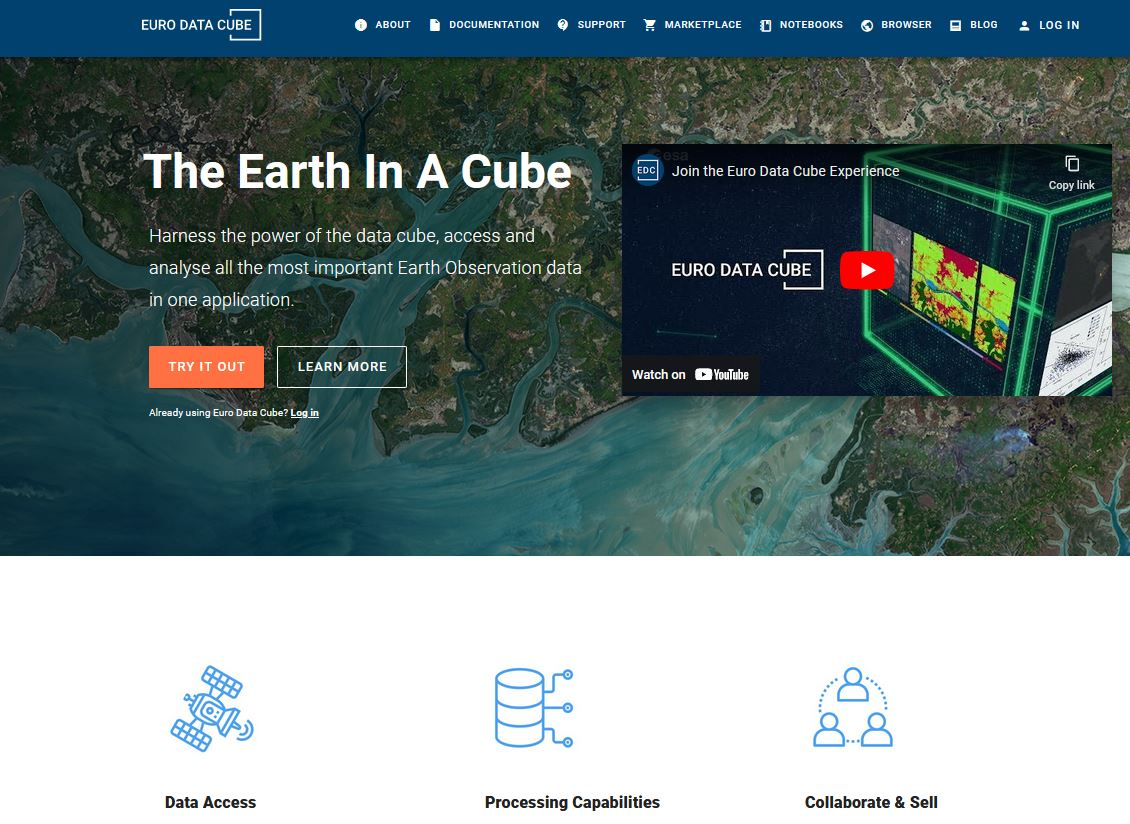

### EDC - cloud-optimized platform offering:
* Access to EO archives from main all open missions (e.g. Sentinel, Landsat, MODIS, etc.), commercial satellites (PlanetScope, Pleiades, SPOT, WorldView, etc.) as well as Level 3 products (Copernicus Land Monitoring Services, C3S, etc.)
* Analyse, compare and correlate EO data through Xcube and operational tools (Sentinel Hub)
* Manage different data formats and type in a transparent way (raster, vector, COGs, Zarr, etc.)
* Bring and store your own data and algorithm for real-time and batch processing operations
* Computational resources and storage to run Jupyter Notebooks and your deployed Applications within your Kubernetes-powered workspace
* Expose your apps on the EDC marketplace to third-parties and provide easy access to your managed API service to customers


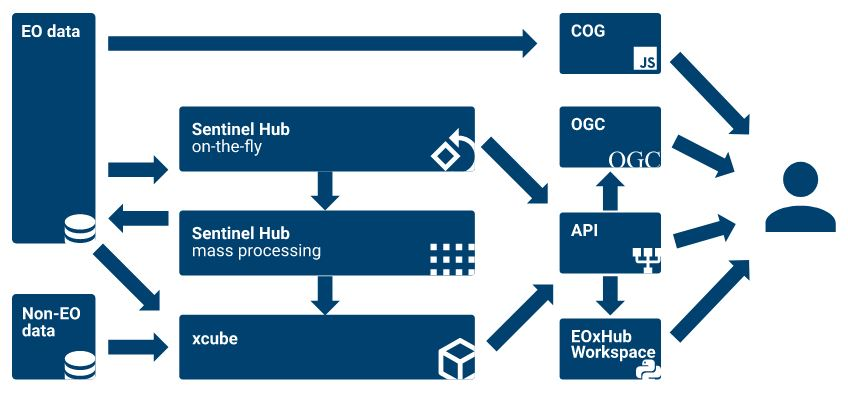

### EDC - [Market Place](https://eurodatacube.com/marketplace)

* Data Products: e.g. [Sentinel Hub](https://www.sentinel-hub.com/) 

**Sentinel Hub** is a multi-spectral and multi-temporal big data satellite imagery service, capable of fully automated archiving, real-time processing and distribution of remote sensing data and related EO products. Users can use APIs to retrieve satellite data over their AOI and specific time range from full archives in a matter of seconds.

* Platform Services: e.g. [EOxHub](https://eurodatacube.com/marketplace/infra/edc_eoxhub_workspace) 

EDC **EOxHub** Workspaces offer managed JupyterLab instances for individual projects or whole workshops. 

* API Services: e.g. [GeoDB](https://eurodatacube.com/marketplace/services/edc_geodb), [SH-Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/)

The xcube **GeoDB** has been developed to generate, manipulate, analyse, and publish geo-spatial feature collections. 
Your data will be stored in a central, cloud-based POSTGIS database and accessible via a Python client provided in a Jupyter Notebook.
GeoDB implements the Postgrest as well as the PostgreSQL query language. All queries return Geopandas Dataframes which allow to immediately analysing your data.

The **Statistical API** enables you to get statistics calculated based on satellite imagery without having to download images. In your Statistical API request, you can specify your area of interest, time period, evalscript and which statistical measures should be calculated. The requested statistics are returned in the API response. 

## Content of this notebook:

1. Visual assessment of wildfire events with Sentinel-2 imagery
2. Querying data via Statistical API for the chosen Area of Interest
3. Transforming the output of the API request into a geoJSON polygon that contains the extent of the built up area in the AOI to be used as binary mask
4. Accessing Sentinel-5p Carbon monoxide data from SentinelHub over the impacted built-up areas 
5. Displaying the time series of the CO concentration over the populated area to evaluate the possible impact of the fire emissions   

This notebook runs with the python environment `users-edc-2023.07-01` and was prepared by Leah Sturm (University of Trier, Germany). 

In [1]:
#import necessary libraries
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import requests
import geojson
from shapely.geometry import shape
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from datetime import datetime


# Sentinel Hub requirements
from sentinelhub import (SHConfig, DataCollection, Geometry, BBox, Geometry,
                         SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType, 
                         SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
                         DownloadFailedException, CRS, SentinelHubStatistical)

In [2]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

client_id = os.environ["SH_CLIENT_ID"]
client_secret = os.environ["SH_CLIENT_SECRET"]


# config

### Create a folder for the session in which all files will be stored

In [3]:
# Get the current date and format it as a string
current_date = datetime.now().strftime("%Y-%m-%d")

# Define the folder name and path
folder_name = f"folder_{current_date}"
folder_path = os.path.join(os.getcwd(), folder_name)

# Check if the folder already exists, and create it if not
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
    print(f"Folder '{folder_name}' created at: {folder_path}")
else:
    print(f"Folder '{folder_name}' already exists at: {folder_path}")

Folder 'folder_2023-11-06' created at: /home/3d76fe8a-ecd3-4736-b462-38f98f1f605e/folder_2023-11-06


## Wildfire Impacts and Carbon Emissions
**The wildfire season during the summer of 2022 in Europe was exceptional, marked by a high number of observed fires, a large extent of burned area, and remarkably high atmospheric emissions linked to these fires.** According to data from the European Forest Fire Information System (EFFIS), fires were reported in 26 out of the 27 European countries, collectively burning 837,212 hectares. A significant portion of these wildfires happened in July, with Spain, Portugal, France, and Italy experiencing the most damages.

The selected wildfire incident for this notebook occurred in the **Gironde region of southwestern France, near the city of Bordeaux, in 2022.** The significant fire event started on **July 17, 2022**, lasted for two weeks while burning approximately 7,000 hectares of land. Notably, the Copernicus Atmosphere Monitoring Service (CAMS) recorded exceptionally elevated levels of carbon monoxide emissions throughout the duration of this event.   

Related articles about the event and the wildfire occurrence in 2022: 
* [European Space Agency](https://www.esa.int/esearch?q=wildfire+france)
* [EU ScienceHub](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/eu-2022-wildfire-season-was-second-worst-record-2023-05-02_en)
* [EFFIS](https://op.europa.eu/en/publication-detail/-/publication/500b8dfa-de5e-11ed-a05c-01aa75ed71a1/language-en)
* [Copernicus Atmosphere Monitoring Service](https://atmosphere.copernicus.eu/europes-summer-wildfire-emissions-highest-15-years)
* [EUMETSAT](https://www.eumetsat.int/summer-2022-exceptional-wildfire-season-europe)

## 1. Visualize Wildfire Event with Sentinel-2
In this first part we are going to visualize the fire event to get an overview of the location and the occuring emissions. In the following cells we will access Sentinel-2 imagery from [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/). Sentinel Hub is a multi-spectral and multi-temporal big data satellite imagery service, capable of fully automated archiving, real-time processing and distribution of remote sensing data and related EO products. Users can use APIs to retrieve satellite data over their AOI and specific time range from full archives in a matter of seconds. The following cells to access Sentinel-2 data are based on the example notebook "Australian Bushfires" which is available in the [Euro Data Cube Marketplace](https://eurodatacube.com/marketplace).   

To get a first overview of the fire event **we are going to look at the true colour image captured on the day of the start of the fire.**

### Define Area of Interest

In [4]:
bbox_coords =[
  -1.006524,
  44.318762,
  -0.406214,
  44.586411
]


resolution = 20
Area_of_interest_bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
Area_of_interest_size = bbox_to_dimensions(Area_of_interest_bbox, resolution=resolution)

# Bbox EPSG
bbox_epsg = 4326

In [5]:
# Utilities
import IPython.display
from IPython.display import display, GeoJSON

# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(bbox_coords,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Access Sentinel-2 data

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).

**The information that we specify in the `SentinelHubRequest` object is:**
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and it’s size (size or resolution).

The evalscript is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands.

In [6]:
# define the evalscript 

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# we nned to specify the collection and the time interval
# for a list of collections available in the Sentinel Hub visit https://docs.sentinel-hub.com/api/latest/data/ 

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A, 
            time_interval=('2022-07-16', '2022-07-18'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=Area_of_interest_bbox,
    size=Area_of_interest_size,
    config=config
)

### Visualize the requested Sentinel image

Image type: uint8


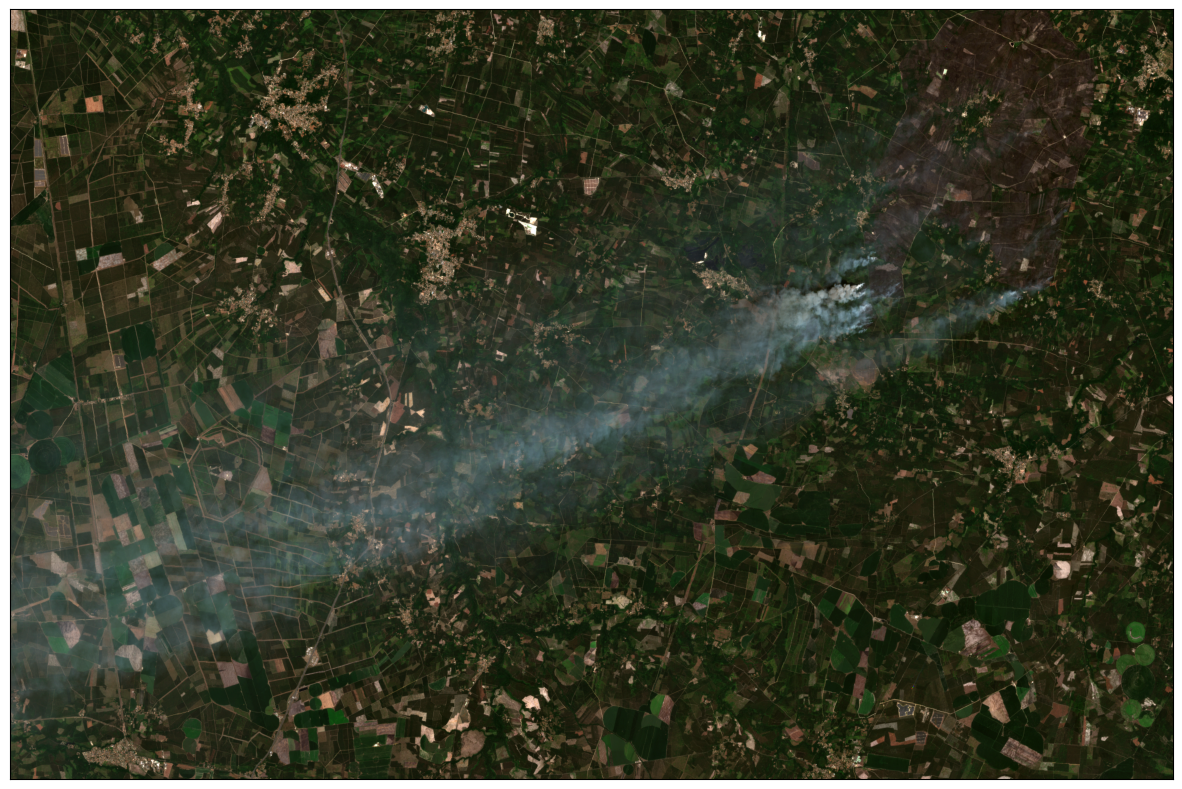

In [8]:
# send the request to Sentinel Hub
#true_color_imgs = request_true_color.get_data()

max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        true_color_imgs = request_true_color.get_data()
        break  # Image displayed successfully, exit the loop
    except Exception as e:
        print(f"Failed to display image: {e}")
        retry_count += 1
        if retry_count < max_retries:
            print(f"Retrying (Attempt {retry_count})...")
 
if retry_count >= max_retries:
    print("Maximum retries reached. Unable to retrieve the image.")
    
# Define the plot_image function

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

image = true_color_imgs[0]
print(f'Image type: {image.dtype}')
    
# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness

# Maximum number of retry attempts

plot_image(image, factor=3.5/255, clip_range=(0,1))

The visualized image captures the start of the  wildfire event which is prominently visible in the top right corner. The plume and emissions from the fire event extend westwards. Consequently, the analysis within this notebook will center around urban areas within those western regions.

### Define and visualize AOI for the analysis

In [9]:
# define the coordinates
top_left_x =  -1.26747
top_left_y = 44.674299
bottom_right_x = -0.962647
bottom_right_y = 44.508045

bbox = [   
  top_left_x,
  bottom_right_y,
  bottom_right_x,
  top_left_y
        ]

# Bbox EPSG
bbox_epsg = 4326

In [10]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(bbox,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Check the resolution and size of the AOI 

In [11]:
# Check the resolution and pixels constrains (they have to be maximal 2500x2500)
resolution = 10
aoi = BBox(bbox=bbox, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi, resolution=resolution)

# These values are needed to set the right dimensions for saving the request as tiff file later
width = aoi_size[0]  
height = aoi_size[1] 

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (2377, 1903) pixels


## 2. Query GHS population density layer with SentinelHub API request
The [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) empowers users to derive insightful statistics from satellite imagery, eliminating the need to download large image files. When making a Statistical API request,it is possible to define an AOI, time frame, evalscript, and the specific statistical measures you wish to compute. The resulting statistics are conveniently included in the API response. With the Statistical API, the user can compute statistics such as cloud pixel percentages within a defined area and timeframe or calculate metrics like mean, standard deviation, and histogram of band values for a specific parcel over a given time frame.

**To query the GHS layer** effectively, we need to provide the:
- BYOC ID 0c7aa265-50f9-4947-9980-2ee5ae204803 found on EDC
- coordinates from the created GeoJSON file as AOI
- desired timeframe
- necessary user credentials as inputs

The GHS layer contains data from 1975 to 2030 in 5 years intervals. **We are going to query the data for 2020** because it is temporally closest to the chosen wildfire event in 2022. 

Source for EC-JRC's GHS layer: Pesaresi, Martino; Politis, Panagiotis (2023): GHS-BUILT-S R2023A - GHS built-up surface grid, derived from Sentinel2 composite and Landsat, multitemporal (1975-2030). European Commission, Joint Research Centre (JRC) [Dataset] doi: 10.2905/9F06F36F-4B11-47EC-ABB0-4F8B7B1D72EA 

**The evalscript in this request creates a new output image where the "dataMask" band is modified based on the values in the GHS layer.**
- GHS value = 0, it masks the pixel in the "dataMask" band by setting it to zero
- Otherwise, it retains the original GHS value

In [12]:
population_dens = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["BUILT", "dataMask"], // this sets which bands to use
    }],
    output: { // this defines the output image type
      bands: 1,
      sampleType: "UINT8"
    }
  };
}
 
function evaluatePixel(sample) {
    let pixelMask = 1
    
    if (sample.BUILT == 0){
        pixelMask = 0
    }
  return {
    default: [sample.BUILT],
    dataMask: [sample.dataMask * pixelMask]
  };
}
"""

request_data = SentinelHubRequest(
    evalscript=population_dens,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('0c7aa265-50f9-4947-9980-2ee5ae204803'),
            time_interval=("2020-01-01", "2020-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi,
    size=aoi_size,
    config=config,
)

In [13]:
population_density = request_data.get_data()

### Extract the population density extent as GeoTiff file   
The GHS layer contains [values ranging](https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2023.pdf?t=1683540422) from 0 to 10,000 square meters (built areas), where higher values indicate greater population density.

In this notebook, **we only exclude pixels with zero values**, but I would be possible to add a threshold to the script below to pinpoint areas of exceptionally high population density.


In [14]:
# the final geotiff is a binary mask with values of 1 representing built-up pixels
image_data_list = population_density

# Calculate pixel width and height based on image shape
pixel_width = (bottom_right_x - top_left_x) /  width 
pixel_height = (top_left_y - bottom_right_y) / height

# Specify the path to the directory where GeoTIFF files will be saved
output_directory = f"./{folder_name}"
# Loop through the list of image arrays
for i, image_data in enumerate(image_data_list):
    # Extract the pixel values (assuming single-band data)
    pixel_values = image_data[:, :]

    # Set values equal to zero to zero, and all other values to 1
    pixel_values = np.where(pixel_values == 0, 0, 1)

    # Specify the output path for each GeoTIFF file with the current time
    output_path = os.path.join(output_directory, f"output_{current_date}.tif")

    # Create a transformation for the GeoTIFF
    transform = from_origin(top_left_x, top_left_y, pixel_width, pixel_height)

    # Open a new GeoTIFF file for writing with NoData value set to NaN
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=pixel_values.shape[0],
        width=pixel_values.shape[1],
        count=1,  # Only one band for pixel values
        dtype=rasterio.float32,  # Use float32 for NaN values
        crs='EPSG:4326',
        transform=transform,
        nodata=np.nan  # Set NoData value to NaN
    ) as dst:
        # Write the pixel values to the GeoTIFF
        dst.write(pixel_values, 1)  # Use band 1


### Visualize the extent of the population density layer

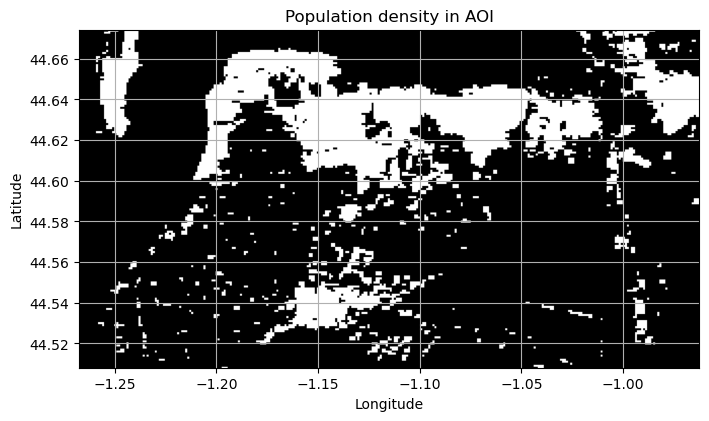

In [15]:
# Specify the path to the GeoTIFF file
geotiff_path = f"./{folder_name}/output_{current_date}.tif"

# Open the GeoTIFF file using rasterio
with rasterio.open(geotiff_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Assuming you have a single band GeoTIFF

    # Get the spatial transformation information
    transform = src.transform

# Calculate the bounds based on the width and height of the raster
left, bottom, right, top = src.bounds

# Plot the GeoTIFF data using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(raster_data, cmap='gray', extent=(left, right, bottom, top), origin='upper')
plt.title('Population density in AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

- Black: **non populated areas**
- White: **populated areas**

From this binary mask we can now **create a GeoJSON file that contains only the populated areas.** 

### 3. Convert the binary raster mask into a GeoJSON file
The resulting GeoJSON will only contain polygons for built up areas and will be used as spatial extent to query the Sentinel-5p data later.

In [16]:
# Specify the path to the GeoTIFF file
geotiff_path = f"./{folder_name}/output_{current_date}.tif"

# Open the GeoTIFF file
with rasterio.open(geotiff_path) as src:
    # Read the binary mask data
    mask = src.read(1)

# Convert the binary mask to vector polygons
geoms = list(shapes(mask, transform=src.transform, connectivity=4))  # Specify connectivity=4 for 4-connected pixels

# Filter the polygons to include only those corresponding to pixels with a value of 1
filtered_geoms = [geom for geom, value in geoms if value == 1]

# Create a GeoDataFrame from the filtered polygons
gdf = gpd.GeoDataFrame({'geometry': [shape(geom) for geom in filtered_geoms]})

# Merge all the geometries into a single MultiPolygon
multi_polygon = gdf.unary_union

# Create a GeoDataFrame with the MultiPolygon geometry
multi_polygon_gdf = gpd.GeoDataFrame(geometry=[multi_polygon], crs=gdf.crs)

# Specify the path to save the MultiPolygon GeoJSON file
output_geojson_file = f"./{folder_name}/multi_polygon_{current_date}.geojson"

# Save the GeoDataFrame with the MultiPolygon to a GeoJSON file
multi_polygon_gdf.to_file(output_geojson_file, driver='GeoJSON')

### Plot the GeoJSON file

In [17]:
display(GeoJSON(data=f"./{folder_name}/multi_polygon_{current_date}.geojson", crs=bbox_epsg))

<IPython.display.GeoJSON object>

We can see that now only the built-up areas are stored in the GeoJSON file and **we can extract the coordinates from this and use them as an input for the Sentinel-5p data.** 

### Extract the coordinates of the created GeoJSON file

In [18]:
with open(f"./{folder_name}/multi_polygon_{current_date}.geojson") as f:
    gj = geojson.load(f)
data_coordinates = gj['features'][0]['geometry']['coordinates']

#print(data_coordinates)

## 4. Use Statistical API request to access Sentinel-5p CO data for the extracted populated areas 

In [19]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [20]:
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

url = "https://creodias.sentinel-hub.com/api/v1/statistics"
headers = {
  "Accept": "application/json",
  "Content-Type": "application/json"
}
data = {
  "input": {
    "bounds": {
      "geometry": {
        "type": "MultiPolygon",
        "coordinates": data_coordinates
                 }
              },
    "data": [
      {
        "dataFilter": {},
        "type": "sentinel-5p-l2"
      }
    ]
  },
  "aggregation": {
    "timeRange": {
      "from": "2022-07-01T00:00:00Z",
      "to": "2022-08-09T23:59:59Z"
    },
    "aggregationInterval": {
      "of": "P1D"
    },
    "width": 512,
    "height": 402.581,
    "evalscript": "//VERSION=3\nfunction setup() {\n  return {\n    input: [{\n      bands: [\"CO\", \"dataMask\"], // this sets which bands to use\n    }],\n    output: [\n      { id:\"default\", bands: 1, sampleType: \"FLOAT32\" },\n      { id: \"dataMask\", bands: 1 }\n    ]\n  };\n}\n \n\n\nfunction evaluatePixel(sample) {\n  return {\n    default: [sample.CO],\n    dataMask: [sample.dataMask]\n  };\n}"
  },
  "calculations": {
    "default": {}
  }
}

response = oauth.post(url, headers=headers, json=data)

### Save the extracted statistics

In [21]:
response_data = response.json()
#print(response_data)

## 5. Plot the statistics for the S5p CO data

In [22]:
time_axis = [datetime.strptime(entry["interval"]["from"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y/%m/%d") for entry in response_data["data"]]
means = [float(entry['outputs']['default']['bands']['B0']['stats']['mean']) for entry in response_data["data"]]
std_devs = [float(entry['outputs']['default']['bands']['B0']['stats']['stDev']) for entry in response_data["data"]]
std_upper = [m+s for (m,s) in zip(means, std_devs)]
std_lower = [m-s for (m,s) in zip(means, std_devs)]

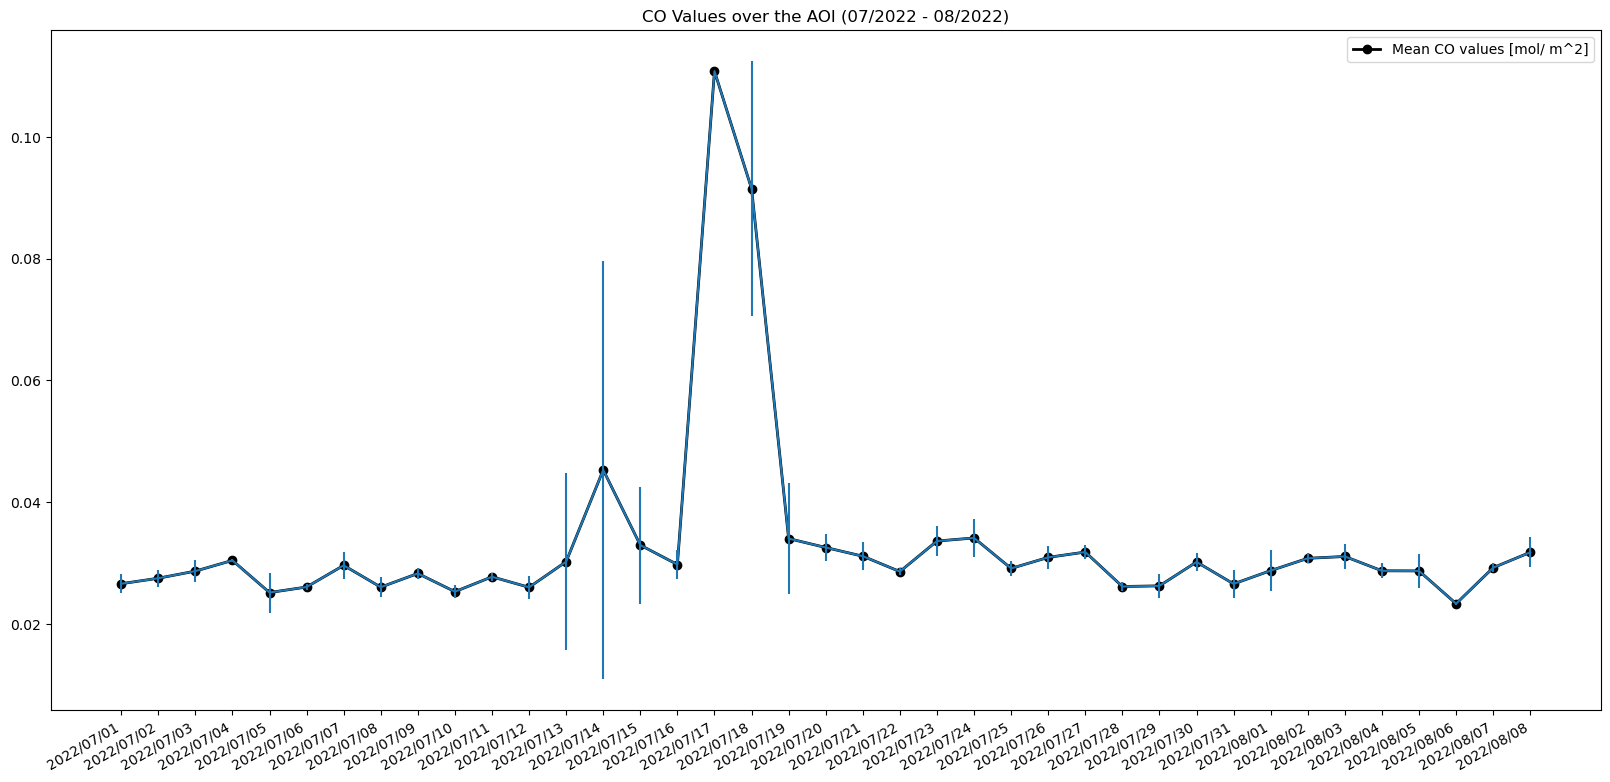

In [23]:
fig = plt.figure(figsize=(20,10))
# plot mean values 
plt.plot_date(time_axis, means, linestyle='solid', linewidth=2, color="black", label="Mean CO values [mol/ m^2]")

# plot standard deviation error bars
plt.errorbar(time_axis, means, yerr=std_devs, linestyle="-")

plt.title('CO Values over the AOI (07/2022 - 08/2022)')
plt.legend()
fig.autofmt_xdate()
plt.show()

The graph illustrates a **noticeable increase in CO concentration across populated areas on July 17th, when the fire event started.** Additionally, the Standard Deviation on this day and the following days is increased in comparison to the days before the fire. The highest [carbon emissions](https://atmosphere.copernicus.eu/europes-summer-wildfire-emissions-highest-15-years) in France were recorded from June to August in 2022 which aligns well with the result of this analysis.

**To learn more** about the carbon emissions resulting from wildfires check out this [story on the EO Dashboard](https://eodashboard.org/story?id=australian-bushfires) that also incorporates further indicators to analyse wildfires. 